In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import display  


In [4]:
# Load data sets
def load_data(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)
    else:
        print(f"Error: File {filepath} not found.")
        return None


data_path = "/Users/jam/Downloads/Team 8/"

datasets = {
    "emission": "emission.csv",
    "penetration": "penetration.csv",
    "power_outages": "power-outages-by-state-2024.csv",
    "rate": "rate.csv",
    "wildfires": "Wildfires_by_state_2023.csv",
    "wf_incident": "WF_Incident.xlsx"
}


loaded_data = {name: load_data(data_path + filename) for name, filename in datasets.items()}


for name, df in loaded_data.items():
    if df is None:
        raise FileNotFoundError(f"Dataset {name} is missing. Please check file paths.")


emission = loaded_data["emission"]
penetration = loaded_data["penetration"]
power_outages = loaded_data["power_outages"]
rate = loaded_data["rate"]
wildfires = loaded_data["wildfires"]
wf_incident = loaded_data["wf_incident"]

print("✅ All datasets loaded successfully!")

✅ All datasets loaded successfully!


In [5]:
print("Merging datasets...")


power_outages.rename(columns={'state': 'State'}, inplace=True)
wildfires.rename(columns={'state': 'State'}, inplace=True)

# Merge all datasets
merged_data = emission.copy()
for dataset in [penetration, power_outages, rate, wildfires]:
    merged_data = pd.merge(merged_data, dataset, on='State', how='left')


print("Handling missing values...")


numeric_cols = merged_data.select_dtypes(include=['number']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)


for col in merged_data.select_dtypes(include=['object']).columns:
    merged_data[col] = merged_data[col].astype(str)


display(merged_data.describe())

print("✅ Data merged and cleaned successfully!")


Merging datasets...
Handling missing values...


,Rank,Annual_Emission_MMT,Population,Annual_Emmision_percapita_MT,Year_x,State-level,PowerOutages,PowerOutagesDurationHours,Year_y,Price_Cents/kWh
count,50.00000,50.000000,5.000000e+01,50.000000,50.0,50.000000,50.000000,50.00000,50.0,50.0
mean,25.50000,102.618000,6.488501e+06,20.593000,2023.0,0.079400,6.880000,158.72000,0.0,0.0
std,14.57738,112.223235,7.315430e+06,17.375121,0.0,0.100171,7.258043,178.34386,0.0,0.0
min,1.00000,5.800000,5.799940e+05,8.000000,2023.0,0.000000,0.000000,0.00000,0.0,0.0
25%,13.25000,40.650000,1.843262e+06,11.232500,2023.0,0.020000,2.000000,5.50000,0.0,0.0
50%,25.50000,77.250000,4.564632e+06,15.615000,2023.0,0.050000,5.000000,89.00000,0.0,0.0
75%,37.75000,114.650000,7.332985e+06,23.087500,2023.0,0.107500,10.750000,233.00000,0.0,0.0
max,50.00000,706.500000,3.933778e+07,104.480000,2023.0,0.460000,39.000000,740.00000,0.0,0.0


✅ Data merged and cleaned successfully!


In [6]:
print("Computing wildfire risk and renewable adoption scores...")

# Convert necessary columns to numeric 
merged_data["Number of fires"] = pd.to_numeric(merged_data["Number of fires"], errors="coerce").fillna(0)
merged_data["State-level"] = pd.to_numeric(merged_data["State-level"], errors="coerce").fillna(0)


merged_data['Wildfire_Risk_Score'] = (
    (merged_data['Number of fires'] - merged_data['Number of fires'].min()) /
    (merged_data['Number of fires'].max() - merged_data['Number of fires'].min())
)


merged_data['Renewable_Potential_Score'] = (
    (merged_data['State-level'] - merged_data['State-level'].min()) /
    (merged_data['State-level'].max() - merged_data['State-level'].min())
)

# Display computed scores
display(merged_data[['State', 'Wildfire_Risk_Score', 'Renewable_Potential_Score']].head())

print("✅ Feature engineering completed successfully!")

Computing wildfire risk and renewable adoption scores...


,State,Wildfire_Risk_Score,Renewable_Potential_Score
0,Wyoming,0.279148,0.043478
1,North Dakota,0.528027,0.000000
2,West Virginia,0.000000,0.021739
3,Louisiana,0.000000,0.065217
4,Alaska,0.387892,0.065217


✅ Feature engineering completed successfully!


Generating visualizations...


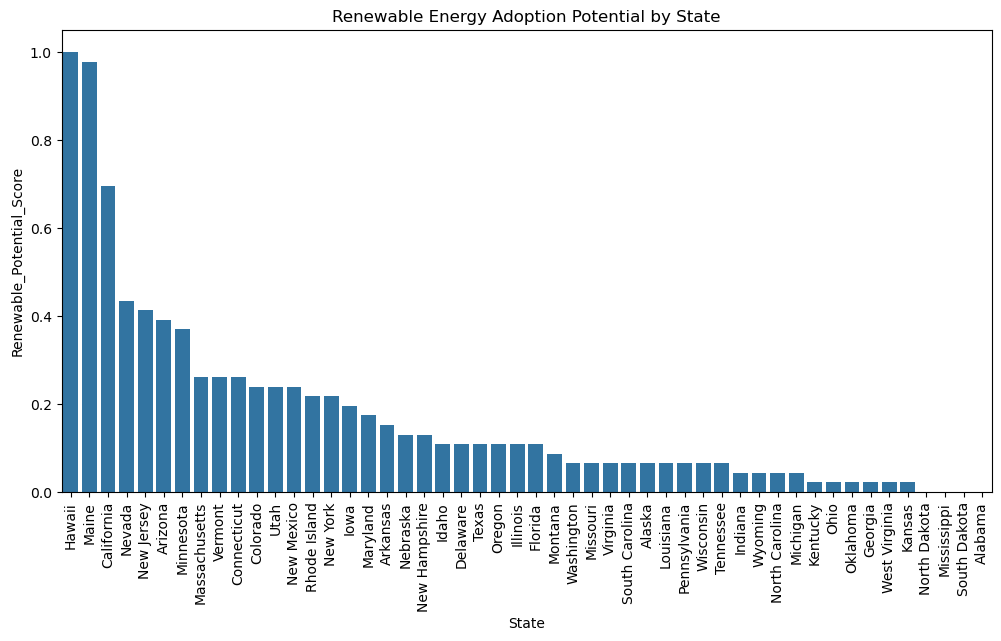

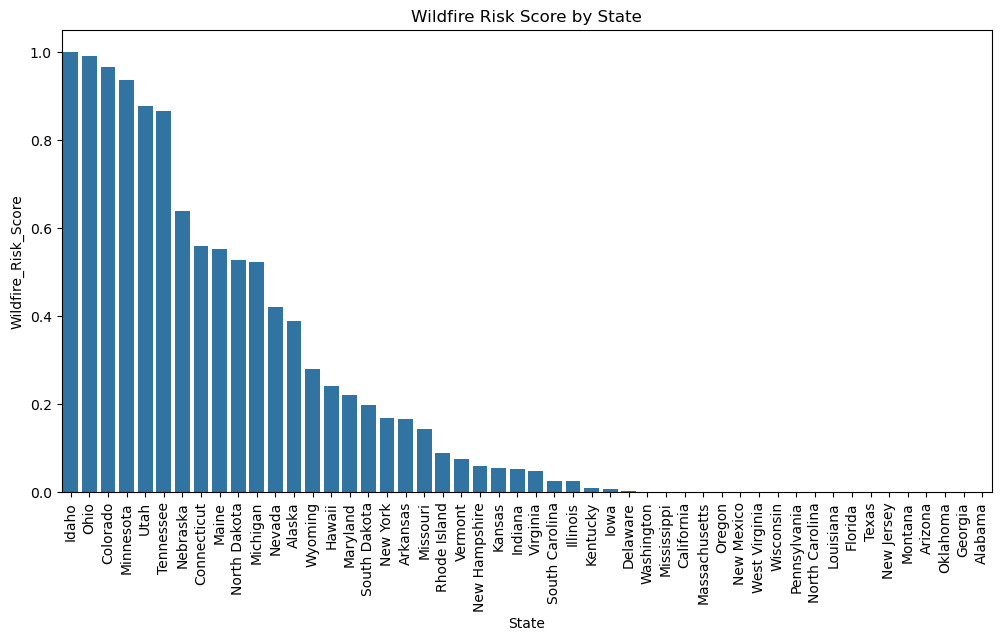

✅ Visualizations generated successfully!


In [7]:
print("Generating visualizations...")

# Renewable Energy Adoption Potential
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Renewable_Potential_Score', 
            data=merged_data.sort_values('Renewable_Potential_Score', ascending=False))
plt.title('Renewable Energy Adoption Potential by State')
plt.xticks(rotation=90)
plt.show()

# Wildfire Risk Score
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Wildfire_Risk_Score', 
            data=merged_data.sort_values('Wildfire_Risk_Score', ascending=False))
plt.title('Wildfire Risk Score by State')
plt.xticks(rotation=90)
plt.show()

print("✅ Visualizations generated successfully!")

Computing combined risk-adjusted renewable adoption scores...


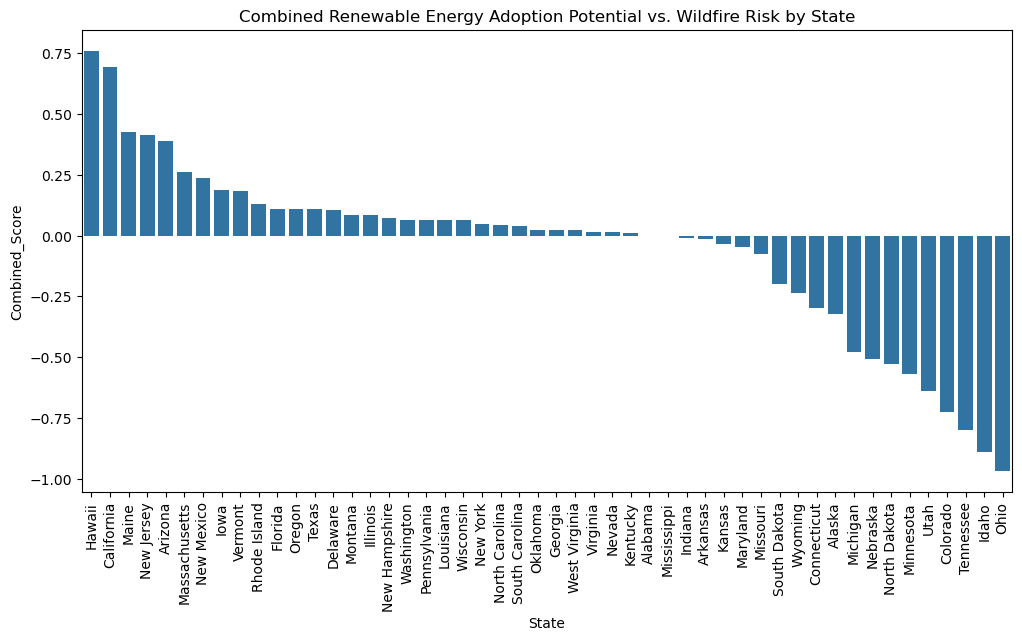

✅ Final scores computed and visualized successfully!


In [8]:
print("Computing combined risk-adjusted renewable adoption scores...")

merged_data['Combined_Score'] = merged_data['Renewable_Potential_Score'] - merged_data['Wildfire_Risk_Score']

plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Combined_Score', 
            data=merged_data.sort_values('Combined_Score', ascending=False))
plt.title('Combined Renewable Energy Adoption Potential vs. Wildfire Risk by State')
plt.xticks(rotation=90)
plt.show()

print("✅ Final scores computed and visualized successfully!")

In [9]:
print("Identifying top states for renewable energy adoption considering wildfire risks...")

top_states = merged_data.sort_values('Combined_Score', ascending=False).head(10)
display(top_states[['State', 'Combined_Score', 'Renewable_Potential_Score', 'Wildfire_Risk_Score']])


output_file = os.path.join(data_path, "final_analysis.csv")
merged_data.to_csv(output_file, index=False)

print(f"✅ Final dataset saved to {output_file}")

Identifying top states for renewable energy adoption considering wildfire risks...


,State,Combined_Score,Renewable_Potential_Score,Wildfire_Risk_Score
31,Hawaii,0.760090,1.000000,0.239910
47,California,0.695652,0.695652,0.000000
35,Maine,0.425570,0.978261,0.552691
36,New Jersey,0.413043,0.413043,0.000000
33,Arizona,0.391304,0.391304,0.000000
46,Massachusetts,0.260870,0.260870,0.000000
12,New Mexico,0.239130,0.239130,0.000000
10,Iowa,0.188926,0.195652,0.006726
44,Vermont,0.185757,0.260870,0.075112
42,Rhode Island,0.129947,0.217391,0.087444


✅ Final dataset saved to /Users/jam/Downloads/Team 8/final_analysis.csv
